In [5]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

Done Mild
Done Moderate
Done No_DR
Done Proliferate_DR
Done Severe


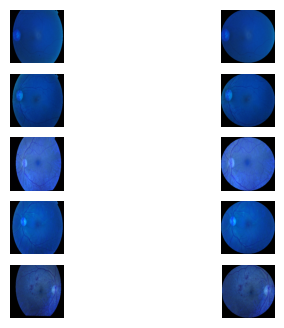

In [7]:
DIR_ORIGIN = "Data/Resized/colored_images/"
DIR_TARGET = "Data/Resized/preprocessed/"

directories = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

c = 0
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(5, 4))
for directory in directories:
    files = os.listdir(DIR_ORIGIN + directory)
    os.makedirs(DIR_TARGET + directory, exist_ok=True)
    for file in files:
        img = circle_crop(DIR_ORIGIN + directory + "/" + file)
        cv2.imwrite(DIR_TARGET + directory + "/" + os.path.basename(file), img)
        if c < 5:
            ax[c, 0].imshow(cv2.imread(DIR_ORIGIN + directory + "/" + file))
            ax[c, 0].axis("off")
            ax[c, 1].imshow(cv2.imread(DIR_TARGET + directory + "/" + file))
            ax[c, 1].axis("off")
            c += 1
    print("Done " + directory)